In [1]:
!pip install torchmetrics==1.7.1 > /dev/null

# Tutorial - Creating a U-Net Convolutional Neural Network for Semantic Image Segmentation

#### Author: Antonio Rueda-Toicen
**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).



![](https://github.com/andandandand/images-for-colab-notebooks/blob/main/challenge-isbi-2012-sample-image.jpeg?raw=true)
**Left:** input image showing the cells of a Drosophila larva's ventral nerve cord, **Right:** segmented cells image with colorized connected components.




**Overview**  
In this notebook, we explore semantic image segmentation using a U-Net model, a type of Convolutional Neural Network (CNN) specifically designed for tasks that involve assigning labels to individual pixels. Semantic segmentation aims to classify each pixel of an image into a predefined category, and U-Net has proven to be highly effective in this task.

The U-Net model was introduced in the influential paper *[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)* by Olaf Ronneberger, Philipp Fischer, and Thomas Brox. This paper demonstrated the model’s strong performance on biomedical segmentation tasks, specifically using electron microscopy data. In this notebook, we will reproduce the core ideas from the U-Net paper (with a few modifications) and apply it to the dataset where it was originally tested: the ISBI 2012 Segmentation Challenge.

We will focus on the Segmentation of Neuronal Structures in Electron Microscopy (EM) stacks challenge from the ISBI 2012 competition. This challenge involves segmenting electron microscopy images to identify neuronal boundaries. The task is particularly challenging due to the complex shapes of neurons.

**Key Goals**
- **Understand U-Net Architecture**: We'll implement a U-Net model and explore its encoder-decoder architecture.
- **Preprocessing and Augmentation**: Image data in this domain requires careful preprocessing. We'll perform steps such as normalization and augmentation to regularize the training process.
- **Model Training and Evaluation**: Using the ISBI 2012 dataset, we will train the U-Net model and evaluate its ability to segment nerve cells. We will explore the tradeoffs between precision and recall that occur when using different thresholds for binarization. These tradeoffs influence greatly the perfomrance of models that we deploy, we will see this in the final testing section.


[Archive page for the ISBI 2012 Segmentation Challenge](https://web.archive.org/web/20211025223842/http://brainiac2.mit.edu/isbi_challenge/)


## What is Semantic Image Segmentation?

Semantic image segmentation is the process of classifying each pixel in an image into a specific category. Instead of assigning one label to the entire image or to a bounding box (like we do in object detection algoritms like RetinaNet and YOLO), semantic segmentation breaks the image down at a pixel level, allowing for more detailed understanding of the content.

For example, in a medical image, different parts like organs or tissues are segmented and labeled. However, semantic segmentation is used in many fields, not just in biomedical image processing. It is also applied in:
- **Self-driving cars**: To identify roads, pedestrians, and other objects.
- **Satellite imagery**: To classify land use like forests, cities, or water bodies.
- **Robotics**: For object detection and manipulation.

This technique helps machines "see" and interpret complex visual data by recognizing the contours of different objects within an image.


## What are Convolutional Neural Networks (CNNs)?

[Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) are a type of deep learning model designed to process visual data. CNNs automatically learn "features" (important characteristics) from images, making them effective for image recognition and analysis tasks.

A CNN works by passing an image through multiple layers, each layer learning specific patterns such as edges, textures, or shapes. These patterns help the model understand and classify different parts of the image.

While CNNs are widely used in biomedical image processing, they are applied in many other fields, such as:
- **Facial recognition**: Used to identify people in photos or videos.
- **Object detection**: To detect objects in real-time for security cameras or self-driving cars.
- **Image search engines**: To retrieve similar images from large datasets.

CNNs are powerful tools for any task that involves understanding and processing visual information.


## Get the data



In [2]:
import skimage.io as io
import matplotlib.pyplot as plt

images_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-train-volume.tif?raw=true'

all_labeled_images = io.imread(images_url)
all_labeled_images.shape

(30, 512, 512)

In [3]:
labels_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-train-labels.tif?raw=true'
label_images = io.imread(labels_url)
label_images.shape

(30, 512, 512)

In [4]:
# the test images have no labels, this was the original competition data
test_images_url = 'https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-test-volume.tif?raw=true'
test_images = io.imread(test_images_url)
test_images.shape

(30, 512, 512)

## Visualizing the image and label pairs


The training data is a set of 30 sections from a serial section Transmission Electron Microscopy (ssTEM) data set of the Drosophila first instar larva ventral nerve cord (VNC). The microcube measures 2 x 2 x 1.5 microns approximately, with a resolution of 4x4x50 nm/pixel.

The corresponding binary labels are white for the pixels of segmented objects and black for the rest of pixels (which are mostly cell membranes).

This is the only data that participants of the ISBI challenge were allowed to use to train their algorithms [source](https://imagej.net/events/isbi-2012-segmentation-challenge).

The **ventral nerve** is a part of the nervous system located in the ventral (or front) part of an organism, typically referring to structures in invertebrates like insects, arthropods, and annelids (segmented worms). It plays a critical role in coordinating movement and transmitting signals from the body to the brain and vice versa.

## What is the ventral nerve cord?

### Key points about the ventral nerve:
1. **Invertebrates**: The ventral nerve cord in invertebrates is analogous to the spinal cord in vertebrates. It consists of a chain of ganglia (clusters of nerve cells) running along the ventral (belly) side of the body.
   
2. **Motor and Sensory Functions**: The ventral nerve cord carries motor signals that control muscle movements and sensory information from various parts of the body.

3. **Segmented Nervous System**: In animals like earthworms or insects, the ventral nerve cord is segmented, with ganglia in each segment responsible for local processing and control, but also connected to the brain for centralized control.

4. **Contrast with Dorsal Nerve**: In vertebrates, the main nerve structures (spinal cord and brain) are located dorsally (on the back side of the body). The ventral nerve in invertebrates, however, is on the underside (belly side).

The ventral nerve cord is a crucial element in the decentralized nervous systems of many invertebrate animals, allowing them to react quickly to environmental stimuli while maintaining overall control of their movements.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets


# Function to display images
def visualize(slider_value):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the original training image
    axes[0].imshow(all_labeled_images[slider_value, :, :], cmap='gray')
    axes[0].set_title('Training Image')
    axes[0].axis('off')  # Turn off axis labels

    # Show the label image without colorization
    axes[1].imshow(label_images[slider_value, :, :], cmap='gray')
    axes[1].set_title('Label Image')
    axes[1].axis('off')  # Turn off axis labels

    plt.show()

# Create an interactive slider widget
slider = widgets.IntSlider(min=0, max=29, step=1, value=16, description="Image Index")
interact(visualize, slider_value=slider);



interactive(children=(IntSlider(value=16, description='Image Index', max=29), Output()), _dom_classes=('widget…

## Split into training and validation sets

todo: ellaborate on why are we doing the split

We need know when we should stop training

In [6]:
import numpy as np


# Calculate sizes for training and validation sets
dataset_size = all_labeled_images.shape[0]
validation_split = 0.3
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size

In [7]:
all_labeled_images.shape

(30, 512, 512)

In [8]:
import numpy as np

np.random.seed(42)
validation_indices =np.random.choice(dataset_size, validation_size, replace=False)
print(validation_indices)

[27 15 23 17  8  9 28 24 12]


In [9]:
all_indices = set(range(0, 29, 1))
train_indices = np.array(list(all_indices - set(validation_indices)))
train_images = all_labeled_images[train_indices]
valid_images = all_labeled_images[validation_indices]

train_labels = label_images[train_indices]
valid_labels = label_images[validation_indices]

In [10]:
max_intensity = np.max(train_images)
max_intensity

np.uint8(255)

array([[126, 107, 122, ..., 161, 164, 177],
       [138, 118, 123, ..., 153, 149, 153],
       [141, 135, 145, ..., 144, 145, 137],
       ...,
       [155, 149, 168, ..., 139, 115, 120],
       [163, 154, 166, ..., 158, 141, 148],
       [151, 141, 160, ..., 183, 164, 171]], dtype=uint8)
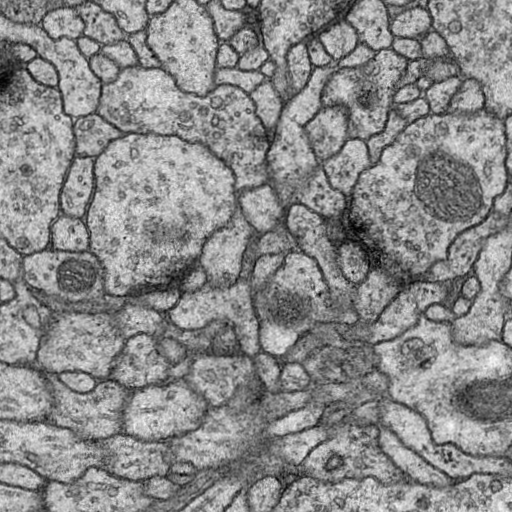

In [11]:
train_images[0]

In [12]:
#We re-scale values to the range 0 to 1 by dividing by max intensity in the training set
train_images = (train_images / max_intensity).astype(np.float32)
valid_images = (valid_images / max_intensity).astype(np.float32)

In [13]:
np.max(train_images)

np.float32(1.0)

In [14]:
# Compute stats that we will use to normalize the data
train_mean, train_std = train_images.flatten().mean(), train_images.flatten().std()
train_mean, train_std

(np.float32(0.497396), np.float32(0.1713885))

## Define a Dataset class

### Why Defining the Dataset Class is Important

In PyTorch, defining a custom `Dataset` class is crucial for working with your data efficiently. The `Dataset` class allows you to load, process, and prepare your data in a structured way, making it easier to work with large datasets and customize the way data is fed into the model.

#### Key Reasons to Define a Dataset Class

1. **Custom Data Handling**: In many cases, datasets aren't stored in simple formats like image files. Defining a custom `Dataset` class lets you load data from specialized formats (e.g., TIFF stacks for medical imaging) and preprocess it, as needed, before feeding it into the model.

2. **Data Transformation**: When training a model, it's essential to preprocess the data (e.g., normalizing, augmenting) and apply transformations consistently. By using a `Dataset` class, we can define transformations like flipping or normalizing within the class, ensuring that every sample goes through the same process before training.

3. **Avoid Data Leakage**: By defining how data is preprocessed in the `Dataset` class, you can ensure that data leakage is avoided. For example, by using the statistics (mean and standard deviation) of the training set when normalizing both the training and validation sets, you ensure that validation data doesn't leak information back into the training process.

4. **Efficient Batching**: The `Dataset` class works well with PyTorch's `DataLoader`, which handles batching, shuffling, and parallel loading of data efficiently. This allows your model to train faster and handle larger datasets without loading everything into memory at once.

In this notebook, the `TIFDataset` class is specifically designed to load a stack of TIFF images and their corresponding labels, apply data augmentation, and normalize the images using the statistics from the training set. This ensures consistency and efficiency throughout the training and validation process.


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import tifffile as tiff

import random
import torchvision.transforms.functional as TF

class TIFDataset(Dataset):
    # Notice that both the training set and the validation set work on train_mean
    # and train_std, this is in order to avoid 'data leakage'.
    # We should assume that during training we only know the stats of the training set
    def __init__(self, images, labels, train_mean,
                 train_std, transform=None):
        super(TIFDataset, self).__init__()
        self.transform = transform
        # Load the entire stack of images and labels
        self.images = images
        self.labels = labels
        self.train_mean = train_mean
        self.train_std = train_std

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(image, label,
                                         self.train_mean, self.train_std)
        return image, label


## Notice that this is outside the TIFDataset class
def train_transform(image, label, train_mean, train_std):

    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((train_mean),(train_std)),
    ])

    label_transform = transforms.ToTensor()

    image = image_transform(image)
    label = label_transform(label)

    # Apply random horizontal and vertical flips synchronously
    if random.random() > 0.5:
        image = TF.hflip(image)
        label = TF.hflip(label)

    if random.random() > 0.5:
        image = TF.vflip(image)
        label = TF.vflip(label)

    return image, label


def valid_transform(image, label, train_mean, train_std):

    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((train_mean),(train_std))
    ])
    label_transform = transforms.ToTensor()

    image = image_transform(image)
    label = label_transform(label)

    return image, label

train_dataset = TIFDataset(train_images, train_labels,
                           train_mean,
                           train_std,
                           transform=train_transform)


val_dataset = TIFDataset(valid_images, valid_labels,
                           train_mean,
                           train_std,
                           transform=train_transform)




In [16]:
len(train_dataset)

20

In [17]:
# the train_dataset has a tuple pair of (image, image_label) on each entry
print(type(train_dataset[0]))
train_dataset[0]

<class 'tuple'>


(tensor([[[ 1.0105,  0.8504,  1.2851,  ...,  0.7588,  0.3241,  0.5529],
          [ 0.4843,  0.3241,  0.7131,  ...,  0.8961,  0.6215,  0.8275],
          [-0.1564, -0.2708,  0.2783,  ...,  0.9419,  0.5071,  0.6444],
          ...,
          [ 0.2326,  0.4156,  0.3927,  ...,  0.4156,  0.1868,  0.3241],
          [ 0.5987,  0.5071,  0.5987,  ..., -0.0878, -0.2022,  0.2554],
          [ 1.1478,  0.8504,  0.7817,  ..., -0.1107, -0.4539, -0.0191]]]),
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]))

## Create DataLoaders

### What are DataLoaders?

`DataLoader` is a PyTorch utility that allows efficient loading of data in batches for model training and evaluation. It works with a `Dataset` and handles the logistics of batching, shuffling, and loading data in parallel. This is essential for speeding up the training process and ensuring that the model receives data in manageable chunks.

### Key Features:
- **Batching**: The `DataLoader` groups samples into batches, enabling the model to process multiple samples at once, which is critical for faster training.
- **Shuffling**: When `shuffle=True`, the `DataLoader` randomizes the order of the samples during each epoch. This helps the model generalize better by exposing it to different data orders.
- **Parallel Loading**: It can load data in parallel using multiple worker threads, ensuring that data is loaded while the model is training.

In the example:
- `train_dataloader` loads training data in batches of 4 with shuffling, ensuring random ordering of samples.
- `valid_dataloader` loads validation data in batches of 4 without shuffling, preserving the order for evaluation.

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## Defining the U-net model

### The Original U-Net Architecture

The U-Net is a convolutional neural network (CNN) designed for image segmentation. It has two parts:
1. **Encoder (Contracting Path)**: Downsamples the input image to capture context.
2. **Decoder (Expanding Path)**: Upsamples to recover spatial information for precise localization.

Though originally developed for biomedical segmentation, U-Net is used in many fields like satellite imagery and self-driving cars.



![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

### Differences In Our Implementation from the Original U-Net

1. **Padding Instead of Cropping**: We use padding to preserve feature map sizes.
2. **Single Output Map**: Our model outputs one feature map instead of two.
3. **Input Image Size**: We use 512x512 images instead of 572x572.
4. **Upsampling Method**: Bilinear interpolation replaces transposed convolutions to reduce artifacts.

The U-Net's skip connections allow it to capture both low- and high-level features, making it effective for precise segmentation.


In [19]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


class UNet(nn.Module):
    """
    This class wraps all components for our UNet
    """
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Here comes a component that extracts features
        # using two Conv2D layers, batch normalization, and ReLu activations
        self.inc = DoubleConv(n_channels, 64)

        # Here we downsample the image, this is the 'encoder' part of the Unet
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)

        # Here we upsample the encoded images, this is 'decoder' part of the Unet
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)

        #this las nn.Conv2d creates a fully connected layer with the '1x1 convolution' name
        #this convolution operates across all input channels, not on the x, y dimensions
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):

        x1 = self.inc(x)

        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        #import pdb; pdb.set_trace()
        logits = self.outc(x)

        return logits

class DoubleConv(nn.Module):
    """
    This section creates the feature extraction
    (convolution => [BN] => ReLU) * 2
    """

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        """We do the downsampling of the features using max-pooling, but we could change this to
           use convolutions of stride = 2"""
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Adjust the number of input channels for the convolution after upsampling
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels // 2 + out_channels, out_channels)

    def forward(self, x, x1):
        """
        We define the skip connections in the forward method of the upsampling path
        Notice that this forward pass receives input from the downsampling path x1
        """
        x = self.up(x)
        # input is Batch Size at index [0], Channels at index [1], Heights at index [2], Width at index [3]
        diffY = x1.size()[2] - x.size()[2]
        diffX = x1.size()[3] - x.size()[3]

        # Before concatenating, we need to make the x, y dimensions agree
        # We can do this with either cropping or padding, in this section we use padding
        # The original Unet diagram uses cropping
        x = TF.pad(x, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])

        # The skip connections concatenate information from the downsampling path with the upsampling path
        # By concatenating of dim=1 we make the feature vector 'thicker' by concatenating on the Channels dimension
        # You can try setting import pdb; set_trace() here to inspect this
        x = torch.cat([x1, x], dim=1)
        return self.conv(x)



In [20]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

## Training

In [21]:
from torchmetrics.classification import BinaryF1Score
from tqdm import tqdm

def validate_model(model, val_loader, criterion):
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    return epoch_val_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = None
    for epoch in tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        epoch_val_loss = validate_model(model, val_loader, criterion)
        val_losses.append(epoch_val_loss)


        # Check if this is the best model so far
        if epoch_val_loss < best_val_loss:
            print("Better weights found, updating best model")
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()


        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

    print('Finished Training')

     # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Plotting the training and validation losses
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


In [22]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# notice that we have a unet that is only modelling the cell body as the positive class when we use n_classes = 1
model = UNet(n_channels=1, n_classes=1).to(device)
#todo: explain what would happen to the losses and output when we change n_classes to 2
criterion = nn.BCEWithLogitsLoss() # n_classes relates to the criterion that we choose to train the network
optimizer = optim.Adam(model.parameters(), lr=0.001)


## When to Use Binary Cross Entropy (BCE) vs Categorical Cross Entropy (CCE) in Semantic Segmentation

### Binary Cross Entropy (BCE)

Use **Binary Cross Entropy** when:
- Performing **binary segmentation**, where each pixel belongs to one of two classes (e.g., **cell body** vs **not cell body**, or background vs not background).
- Conducting **multi-label segmentation**, where pixels can belong to multiple classes simultaneously. In this scenario, each class is treated independently as a separate binary classification problem.

**Example:** Segmenting an image into "cell body" vs. "cell wall." with "cell wall" encoded as "not cell body"  Each pixel prediction is a probability between 0 and 1, matching the binary target values.

**BCE Formula:**

$$
\text{BCE} = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)]
$$

- $ n $: number of pixels or samples
- $ y_i $: ground truth label (0 or 1)
- $ \hat{y}_i $: predicted probability (between 0 and 1)

### Categorical Cross Entropy (CCE)

Use **Categorical Cross Entropy** when:
- Performing **multi-class segmentation**, where each pixel belongs exclusively to one of several classes.

**Example:** Segmenting pixels into multiple different tissue types or distinct objects. Ground truth labels are represented as one-hot encoded vectors, and predictions provide a probability distribution across all classes for each pixel.

### Summary

- **BCE** for binary or multi-label segmentation tasks, treating each class independently.
- **CCE** for multi-class segmentation, where each pixel belongs to exactly one class.



  2%|▏         | 1/50 [00:04<03:25,  4.19s/it]

Better weights found, updating best model
Epoch 1/50, Train Loss: 0.4743, Validation Loss: 0.6113


  4%|▍         | 2/50 [00:07<03:02,  3.81s/it]

Better weights found, updating best model
Epoch 2/50, Train Loss: 0.3668, Validation Loss: 0.5186


  6%|▌         | 3/50 [00:11<02:53,  3.69s/it]

Better weights found, updating best model
Epoch 3/50, Train Loss: 0.3306, Validation Loss: 0.3984


  8%|▊         | 4/50 [00:14<02:47,  3.64s/it]

Better weights found, updating best model
Epoch 4/50, Train Loss: 0.3035, Validation Loss: 0.3709


 10%|█         | 5/50 [00:18<02:42,  3.62s/it]

Better weights found, updating best model
Epoch 5/50, Train Loss: 0.2856, Validation Loss: 0.3200


 12%|█▏        | 6/50 [00:22<02:38,  3.61s/it]

Better weights found, updating best model
Epoch 6/50, Train Loss: 0.2768, Validation Loss: 0.2801


 14%|█▍        | 7/50 [00:25<02:35,  3.61s/it]

Epoch 7/50, Train Loss: 0.2624, Validation Loss: 0.2861


 16%|█▌        | 8/50 [00:29<02:31,  3.61s/it]

Epoch 8/50, Train Loss: 0.2526, Validation Loss: 0.2869


 18%|█▊        | 9/50 [00:32<02:28,  3.62s/it]

Better weights found, updating best model
Epoch 9/50, Train Loss: 0.2458, Validation Loss: 0.2780


 20%|██        | 10/50 [00:36<02:24,  3.62s/it]

Better weights found, updating best model
Epoch 10/50, Train Loss: 0.2458, Validation Loss: 0.2630


 22%|██▏       | 11/50 [00:40<02:21,  3.63s/it]

Better weights found, updating best model
Epoch 11/50, Train Loss: 0.2387, Validation Loss: 0.2595


 24%|██▍       | 12/50 [00:43<02:18,  3.64s/it]

Better weights found, updating best model
Epoch 12/50, Train Loss: 0.2342, Validation Loss: 0.2388


 26%|██▌       | 13/50 [00:47<02:15,  3.65s/it]

Better weights found, updating best model
Epoch 13/50, Train Loss: 0.2259, Validation Loss: 0.2340


 28%|██▊       | 14/50 [00:51<02:11,  3.67s/it]

Epoch 14/50, Train Loss: 0.2258, Validation Loss: 0.2444


 30%|███       | 15/50 [00:54<02:08,  3.68s/it]

Better weights found, updating best model
Epoch 15/50, Train Loss: 0.2152, Validation Loss: 0.2232


 32%|███▏      | 16/50 [00:58<02:05,  3.70s/it]

Epoch 16/50, Train Loss: 0.2155, Validation Loss: 0.2424


 34%|███▍      | 17/50 [01:02<02:02,  3.71s/it]

Epoch 17/50, Train Loss: 0.2151, Validation Loss: 0.2459


 36%|███▌      | 18/50 [01:06<01:59,  3.72s/it]

Better weights found, updating best model
Epoch 18/50, Train Loss: 0.2150, Validation Loss: 0.2209


 38%|███▊      | 19/50 [01:09<01:55,  3.73s/it]

Epoch 19/50, Train Loss: 0.2112, Validation Loss: 0.2438


 40%|████      | 20/50 [01:13<01:52,  3.75s/it]

Epoch 20/50, Train Loss: 0.2039, Validation Loss: 0.2635


 42%|████▏     | 21/50 [01:17<01:49,  3.76s/it]

Epoch 21/50, Train Loss: 0.2028, Validation Loss: 0.2265


 44%|████▍     | 22/50 [01:21<01:45,  3.79s/it]

Epoch 22/50, Train Loss: 0.2056, Validation Loss: 0.2234


 46%|████▌     | 23/50 [01:25<01:42,  3.80s/it]

Better weights found, updating best model
Epoch 23/50, Train Loss: 0.2033, Validation Loss: 0.2030


 48%|████▊     | 24/50 [01:29<01:39,  3.82s/it]

Epoch 24/50, Train Loss: 0.1991, Validation Loss: 0.2211


 50%|█████     | 25/50 [01:32<01:35,  3.84s/it]

Epoch 25/50, Train Loss: 0.2026, Validation Loss: 0.2125


 52%|█████▏    | 26/50 [01:36<01:32,  3.85s/it]

Epoch 26/50, Train Loss: 0.2041, Validation Loss: 0.2205


 54%|█████▍    | 27/50 [01:40<01:28,  3.86s/it]

Epoch 27/50, Train Loss: 0.2035, Validation Loss: 0.2110


 56%|█████▌    | 28/50 [01:44<01:25,  3.88s/it]

Epoch 28/50, Train Loss: 0.1969, Validation Loss: 0.2094


 58%|█████▊    | 29/50 [01:48<01:21,  3.89s/it]

Better weights found, updating best model
Epoch 29/50, Train Loss: 0.1937, Validation Loss: 0.1977


 60%|██████    | 30/50 [01:52<01:18,  3.91s/it]

Better weights found, updating best model
Epoch 30/50, Train Loss: 0.1903, Validation Loss: 0.1976


 62%|██████▏   | 31/50 [01:56<01:14,  3.93s/it]

Epoch 31/50, Train Loss: 0.1879, Validation Loss: 0.2004


 64%|██████▍   | 32/50 [02:00<01:10,  3.94s/it]

Epoch 32/50, Train Loss: 0.1901, Validation Loss: 0.2095


 66%|██████▌   | 33/50 [02:04<01:06,  3.94s/it]

Epoch 33/50, Train Loss: 0.1924, Validation Loss: 0.2062


 68%|██████▊   | 34/50 [02:08<01:02,  3.93s/it]

Epoch 34/50, Train Loss: 0.1930, Validation Loss: 0.2029


 70%|███████   | 35/50 [02:12<00:58,  3.92s/it]

Epoch 35/50, Train Loss: 0.1866, Validation Loss: 0.2142


 72%|███████▏  | 36/50 [02:15<00:54,  3.90s/it]

Epoch 36/50, Train Loss: 0.1967, Validation Loss: 0.2138


 74%|███████▍  | 37/50 [02:19<00:50,  3.90s/it]

Epoch 37/50, Train Loss: 0.1909, Validation Loss: 0.2788


 76%|███████▌  | 38/50 [02:23<00:46,  3.89s/it]

Epoch 38/50, Train Loss: 0.1940, Validation Loss: 0.2068


 78%|███████▊  | 39/50 [02:27<00:42,  3.88s/it]

Epoch 39/50, Train Loss: 0.1893, Validation Loss: 0.2225


 80%|████████  | 40/50 [02:31<00:38,  3.87s/it]

Epoch 40/50, Train Loss: 0.1913, Validation Loss: 0.2022


 82%|████████▏ | 41/50 [02:35<00:34,  3.87s/it]

Epoch 41/50, Train Loss: 0.1913, Validation Loss: 0.2030


 84%|████████▍ | 42/50 [02:39<00:30,  3.87s/it]

Epoch 42/50, Train Loss: 0.1891, Validation Loss: 0.2120


 86%|████████▌ | 43/50 [02:43<00:27,  3.87s/it]

Epoch 43/50, Train Loss: 0.1917, Validation Loss: 0.2492


 88%|████████▊ | 44/50 [02:46<00:23,  3.87s/it]

Epoch 44/50, Train Loss: 0.1915, Validation Loss: 0.2114


 90%|█████████ | 45/50 [02:50<00:19,  3.87s/it]

Epoch 45/50, Train Loss: 0.1834, Validation Loss: 0.1982


 92%|█████████▏| 46/50 [02:54<00:15,  3.87s/it]

Better weights found, updating best model
Epoch 46/50, Train Loss: 0.1810, Validation Loss: 0.1975


 94%|█████████▍| 47/50 [02:58<00:11,  3.87s/it]

Epoch 47/50, Train Loss: 0.1779, Validation Loss: 0.1978


 96%|█████████▌| 48/50 [03:02<00:07,  3.87s/it]

Epoch 48/50, Train Loss: 0.1767, Validation Loss: 0.2079


 98%|█████████▊| 49/50 [03:06<00:03,  3.88s/it]

Epoch 49/50, Train Loss: 0.1825, Validation Loss: 0.2232


100%|██████████| 50/50 [03:10<00:00,  3.80s/it]

Epoch 50/50, Train Loss: 0.1780, Validation Loss: 0.2040
Finished Training


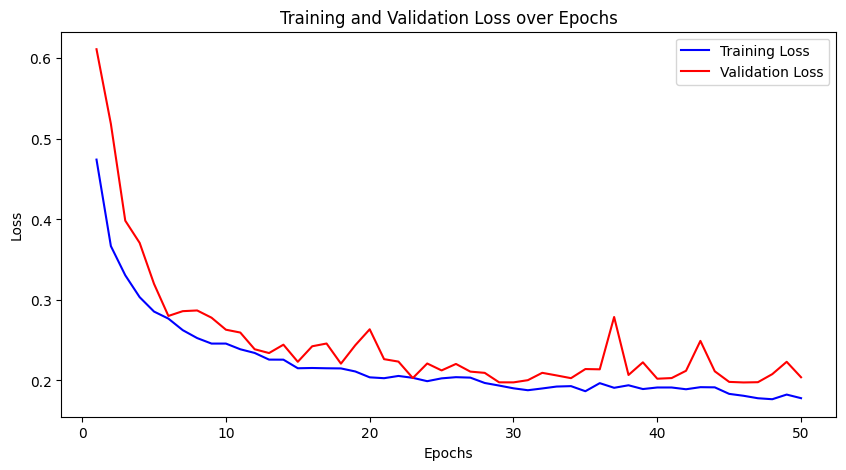

In [23]:
trained_model = train_model(model, train_loader, val_loader,
                            criterion, optimizer, num_epochs=50)


## Compute performance metrics and select the optimal threshold for labeling positives

In [24]:
# We use torchmetrics to compute precision, recall, and the f1 measure
!pip install torchmetrics -q

In [25]:
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryFBetaScore


In [26]:
import torch.nn.functional as F

images, labels = next(iter(valid_dataloader))

trained_model.eval()
with torch.no_grad():
    logits_pred = trained_model(images.to(device))

probs_pred = F.sigmoid(logits_pred)

In [27]:
len(val_dataset)

9

## Selecting a binarization threshold on the validation set

In [28]:
# Import necessary library for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def visualize_predictions(slider_value, threshold_value):
    # Prepare the input image
    input_image = images[slider_value].cpu()
    if input_image.shape[0] == 1:
        # Grayscale image
        input_image = input_image.squeeze(0)
        cmap_input = 'gray'
    else:
        # RGB image
        input_image = np.transpose(input_image, (1, 2, 0))
        cmap_input = None

    # Prepare the probability image
    probs_image = probs_pred[slider_value].cpu()
    if probs_image.shape[0] == 1:
        probs_image = probs_image.squeeze(0)
        cmap_probs = 'gray'
    else:
        probs_image = np.transpose(probs_image, (1, 2, 0))
        cmap_probs = None

    # Binarize the probability image based on the threshold
    binarized_image = probs_image > threshold_value
    cmap_binarized = 'gray'

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the input image
    axes[0, 0].imshow(input_image, cmap=cmap_input)
    axes[0, 0].set_title('Input Image')
    axes[0, 0].axis('off')

    # Plot the probability image
    axes[0, 1].imshow(probs_image, cmap=cmap_probs)
    axes[0, 1].set_title('Probability Image')
    axes[0, 1].axis('off')

    # Plot the binarized image
    axes[0, 2].imshow(binarized_image, cmap=cmap_binarized)
    axes[0, 2].set_title('Binarized Image')
    axes[0, 2].axis('off')

    # Plot histogram of pixel intensities in the input image
    if input_image.ndim == 2:
        # Grayscale image
        pixel_values = input_image.flatten()
    else:
        # RGB image
        pixel_values = input_image.reshape(-1, 3)
        pixel_values = pixel_values.mean(axis=1)
    axes[1, 0].hist(pixel_values, bins=256, color='gray', alpha=0.7)
    axes[1, 0].set_title('Pixel Intensity Histogram')
    axes[1, 0].set_xlabel('Intensity')
    axes[1, 0].set_ylabel('Frequency')

    # Plot histogram of probabilities in the probability image
    axes[1, 1].hist(probs_image.flatten(), bins=50, color='blue', alpha=0.7)
    axes[1, 1].set_title('Probability Distribution')
    axes[1, 1].set_xlabel('Probability')
    axes[1, 1].set_ylabel('Frequency')

    # Plot bar chart of the number of 1s and 0s in the binarized image
    counts = np.bincount(binarized_image.cpu().numpy().flatten().astype(int))
    counts = np.pad(counts, (0, 2 - len(counts)), 'constant')  # Ensure counts for both 0 and 1
    axes[1, 2].bar([0, 1], counts, color=['red', 'green'])
    axes[1, 2].set_xticks([0, 1])
    axes[1, 2].set_xticklabels(['0s', '1s'])
    axes[1, 2].set_title('Counts of 0s and 1s')
    axes[1, 2].set_ylabel('Count')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

    # Compute and print the confusion matrix
    # Retrieve the ground truth label for the selected image
    _, ground_truth_label = val_dataset[slider_value]
    ground_truth_label = ground_truth_label.cpu()
    if ground_truth_label.shape[0] == 1:
        ground_truth_label = ground_truth_label.squeeze(0)
    else:
        ground_truth_label = np.transpose(ground_truth_label, (1, 2, 0))

    # Flatten the ground truth and predicted labels
    ground_truth = ground_truth_label.numpy().flatten().astype(int)
    predicted = binarized_image.cpu().numpy().flatten().astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, predicted)
    tn, fp, fn, tp = cm.ravel()

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(f"True positives = {tp}")
    print(f"False positives = {fp}")
    print(f"True negatives = {tn}")
    print(f"False negatives = {fn}")


    # Visualize the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Create interactive sliders for image index and threshold
slider_value_widget = widgets.IntSlider(min=0, max=(len(val_dataset)-1), step=1,
                                        value=0, description="Image Index")
threshold_value_widget = widgets.FloatSlider(min=0, max=1.0, step=0.01,
                                             value=0.7, description="Threshold")

# Use interact to update the plot dynamically
interact(visualize_predictions, slider_value=slider_value_widget,
         threshold_value=threshold_value_widget);


interactive(children=(IntSlider(value=0, description='Image Index', max=8), FloatSlider(value=0.7, description…

In [29]:
precision = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
f1 = BinaryF1Score().to(device)
fbeta = BinaryFBetaScore(beta=0.25).to(device)

def evaluate_prec_rec_f_one(images, labels_gt, trained_model, threshold=0.5, print_probs=False):

    trained_model.eval()

    with torch.no_grad():
        logits_pred = trained_model(images.to(device))
    probs_pred = F.sigmoid(logits_pred)
    if print_probs:
        print(f'Min/max probabilities: {probs_pred.min().item()}, {probs_pred.max().item()}')
    labels_pred = (probs_pred >= threshold).float()

    prec = precision(labels_pred.to(device), labels_gt.to(device)).item()
    rec = recall(labels_pred.to(device), labels_gt.to(device)).item()
    f_one = f1(labels_pred.to(device), labels_gt.to(device)).item()
    f_bet = fbeta(labels_pred.to(device), labels_gt.to(device)).item()


    return prec, rec, f_one, f_bet

In [30]:
lower_limit = 0.01
upper_limit = 1.0
stepsize= 0.01
arr_plt = np.array([evaluate_prec_rec_f_one(images, labels, trained_model, threshold=t) for t in np.arange(lower_limit, upper_limit, stepsize)])

In [31]:
scores_data = np.column_stack((arr_plt, np.arange(lower_limit, upper_limit, stepsize)))
import pandas as pd
scores_df = pd.DataFrame(scores_data, columns = ['precision','recall',
                                                 'f1','fbeta',
                                                 'threshold'])
scores_df

,precision,recall,f1,fbeta,threshold
0,0.790354,0.999990,0.882899,0.800222,0.01
1,0.798363,0.999908,0.887841,0.807942,0.02
2,0.808472,0.999726,0.893984,0.817674,0.03
3,0.818195,0.999381,0.899757,0.827014,0.04
4,0.826755,0.998968,0.904739,0.835225,0.05
...,...,...,...,...,...
94,0.992312,0.815132,0.895038,0.979785,0.95
95,0.993068,0.803944,0.888554,0.979514,0.96
96,0.993961,0.788959,0.879675,0.978998,0.97
97,0.995022,0.764117,0.864415,0.977644,0.98


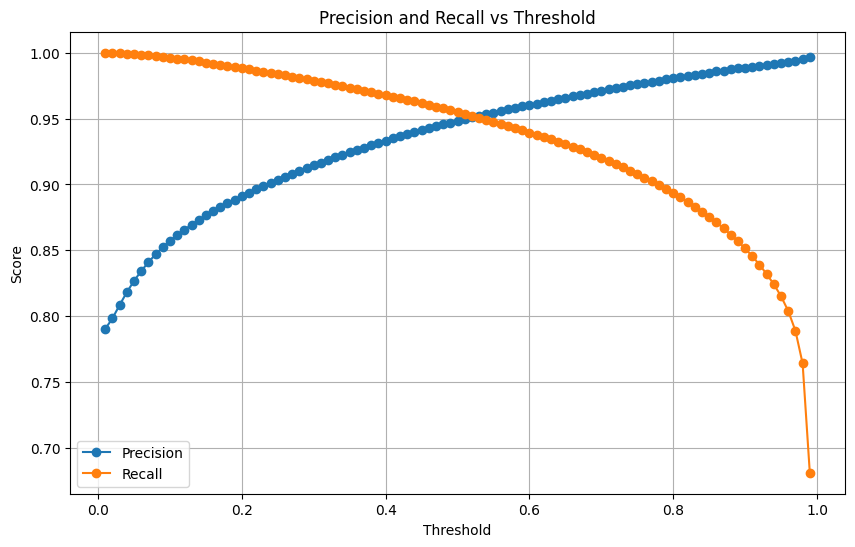

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(scores_df['threshold'], scores_df['precision'], label='Precision', marker='o')
plt.plot(scores_df['threshold'], scores_df['recall'], label='Recall', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


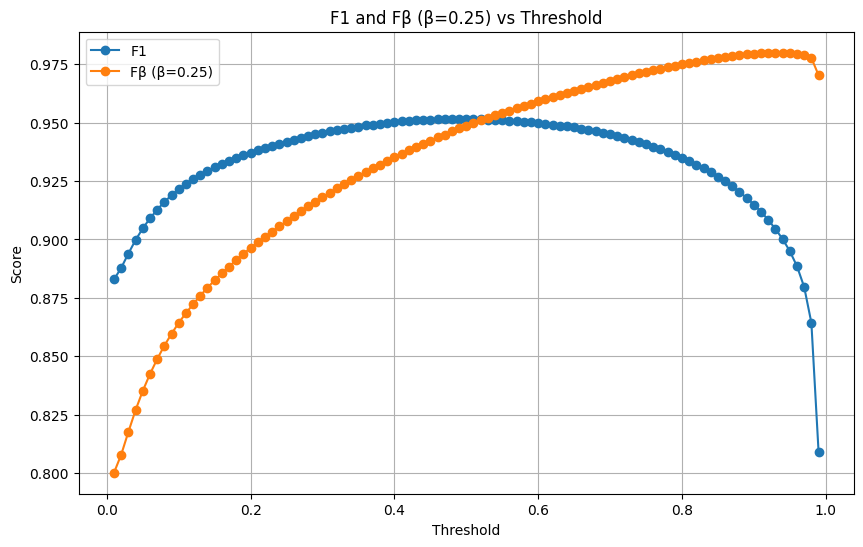

In [33]:
# Plot F1 and Fbeta (beta=0.25) vs threshold
plt.figure(figsize=(10, 6))
plt.plot(scores_df['threshold'], scores_df['f1'], label='F1', marker='o')
plt.plot(scores_df['threshold'], scores_df['fbeta'], label='Fβ (β=0.25)', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 and Fβ (β=0.25) vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
max_f1_row = scores_df.loc[scores_df['f1'].idxmax()]
print(max_f1_row)


precision    0.946996
recall       0.956300
f1           0.951625
fbeta        0.947538
threshold    0.490000
Name: 48, dtype: float64


In [35]:
max_fbeta_row = scores_df.loc[scores_df['fbeta'].idxmax()]
print(max_fbeta_row)

precision    0.991591
recall       0.824239
f1           0.900203
fbeta        0.979888
threshold    0.940000
Name: 93, dtype: float64


In [36]:
evaluate_prec_rec_f_one(images, labels, trained_model, threshold=0.01)

(0.7903538942337036,
 0.9999903440475464,
 0.8828986287117004,
 0.8002219796180725)

In [37]:
evaluate_prec_rec_f_one(images, labels, trained_model, threshold=0.5)

(0.9483424425125122, 0.9547611474990845, 0.951541006565094, 0.9487176537513733)

In [38]:
evaluate_prec_rec_f_one(images, labels, trained_model, threshold=0.99)

(0.9967705607414246,
 0.6811742186546326,
 0.8092929124832153,
 0.9703255891799927)

## Testing (without Ground Truth Labels)

Depending on the metric that we choose to maximize, we select different thresholds for deployment.

In [39]:
max_f1_row['threshold']

np.float64(0.49)

In [40]:
max_fbeta_row['threshold']

np.float64(0.9400000000000001)

In [41]:
class TestTIFDataset(Dataset):
    """The test dataset comes without labels"""
    def __init__(self, test_images, transform=None):
        self.transform = transform
        self.images = test_images

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image


test_transforms = transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Normalize((train_mean),(train_std))
                ])
test_images = io.imread('https://github.com/andandandand/images-for-colab-notebooks/blob/main/fruit-fly-neurons-test-volume.tif?raw=true')
test_dataset = TestTIFDataset(test_images,
                              transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [42]:
len(test_dataset)

30

In [43]:
# We now have a batch with only 1 grayscale image
next(iter(test_dataloader)).shape

torch.Size([1, 1, 512, 512])

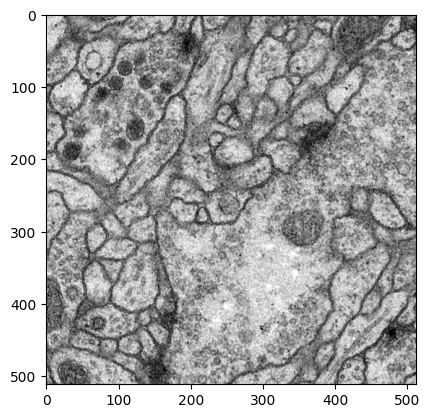

In [44]:
test_images = next(iter(test_dataloader))
plt.imshow(test_images.squeeze(), cmap="gray");

In [45]:
#todo: run inference on the test image, show input and output, deploy
#the inference at the threshold found during validation that maximizes f1 score vs f0.25 score
test_probs = F.sigmoid(model(test_images.to(device)))

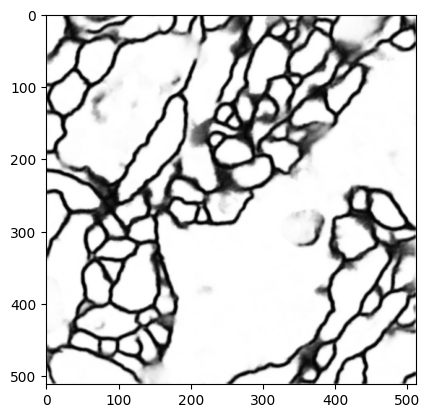

In [46]:
plt.imshow(test_probs.squeeze().detach().cpu(), cmap='gray');

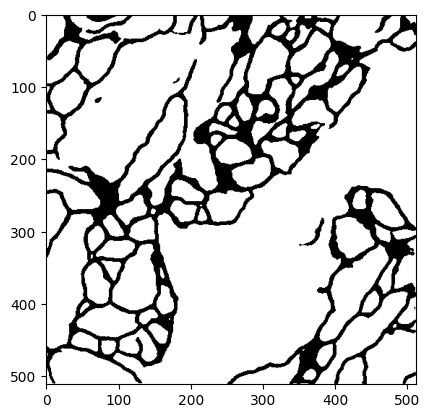

In [47]:
plt.imshow(test_probs.squeeze().detach().cpu() >= max_f1_row['threshold'], cmap='gray');

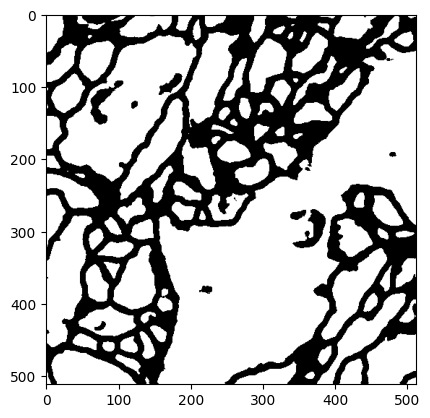

In [48]:
plt.imshow(test_probs.squeeze().detach().cpu() >= max_fbeta_row['threshold'], cmap='gray');

## Extra: colorize the connected components of the segmentation label

https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.colors import ListedColormap


# Function to apply connected components trick
def colorize_labels(labels):
    labeled_array, num_features = ndi.label(labels)
    return labeled_array

# Create a colormap where label 0 is black
def create_custom_cmap():
    cmap = plt.colormaps.get_cmap('tab20')  # Get the 'tab20' colormap
    colors = cmap(np.arange(20))  # Get all 20 colors
    colors[0] = [0, 0, 0, 1]  # Set the color for label 0 to black
    return ListedColormap(colors)

# Function to display images with overlay
def visualize(slider_value):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show the original training image in grayscale on the first axis
    axes[0].imshow(all_labeled_images[slider_value, :, :], cmap='gray')
    axes[0].set_title('Training Image')
    axes[0].axis('off')  # Turn off axis labels

    # Show the original training image in grayscale on the second axis
    axes[1].imshow(all_labeled_images[slider_value, :, :], cmap='gray')

    # Colorize the label image
    colored_labels = colorize_labels(label_images[slider_value, :, :])

    # Overlay the label image with transparency (alpha) and custom colormap
    axes[1].imshow(colored_labels, cmap=create_custom_cmap(), alpha=0.5)  # Set alpha for transparency
    axes[1].set_title('Training Image with Label Overlay')
    axes[1].axis('off')  # Turn off axis labels

    plt.show()

# Create an interactive slider widget
slider = widgets.IntSlider(min=0, max=29, step=1, value=16, description="Image Index")
interact(visualize, slider_value=slider);


interactive(children=(IntSlider(value=16, description='Image Index', max=29), Output()), _dom_classes=('widget…

## Wrap-up

This notebook demonstrated how to apply a U-Net architecture for semantic segmentation using electron microscopy (EM) images of neuronal structures from the ISBI 2012 challenge.

### Key Takeaways

- **U-Net for Biomedical Segmentation**: U-Net is highly effective for pixel-wise segmentation, particularly in medical imaging, due to its ability to capture both context and fine details through skip connections.
- **Selecting the Binarization Threshold**: Determining whether precision or recall is more important for us has a huge effect on the predictions that we serve. We should do this exploration exhaustively, instead of just labeling as 'positive' every pixel with probability >= 0.5.





## Review questions

1. Try what happens when removing the normalization. How does this affect the probabilities that come out of the final layer?

2. What would change in the loss function and the evaluation of performance if we start outputting two classes for the cell wall and cell body (instead of only giving as output the cell body)?

3. What is the relationship between increasing the threshold for positive prediction and the precision score?

4. What is the relationship between increasing the threshold for positive prediction and the recall score?

